In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from itertools import product
from time import sleep
from tqdm import tqdm
import chocopearl as ch
import os
from datetime import datetime, timedelta
import seaborn as sns
import re
import unicodedata
import hashlib

def check_order(xs, ys):
    xs = np.array(xs)
    ys = np.array(ys)

    dx = xs[-1] - xs[0]
    dy = ys[-1] - ys[0]
    
    projections= (xs - xs[0]) * dx + (ys - ys[0]) * dy

    return np.all(np.diff(projections) >= 0)

def valid_filename(text):
    text = text.replace(" ", "_")
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('ascii')
    text = re.sub(r'[^a-zA-Z0-9_.-]', '', text)
    if not text:
        text = hashlib.sha256(text_original.encode('utf-8')).hexdigest()[:8]
    return text+'.png' 

### Load multiple pickles

In [3]:
directory = '/home/pc-igp-173/Documentos/DATA/cosmic_rays/jun2023_oblique'
file_paths=ch.list_files(directory)[1]

In [4]:
crs = []
i=1
for file_path in file_paths:
    with open(file_path, 'rb') as f:
        print(f'processing {os.path.basename(file_path)}')
        not_end=True
        while not_end:
            try:
                obj = pickle.load(f)
                crs.append(obj)
                #clear_output(wait=True)
                #print(f"CosmicRay: {i}")
                i+=1
            except EOFError as e:
                not_end=False
print(f'Total: {i} Cosmic Rays')

processing trails_jun2023_9_CR.pickle
processing trails_jun2023_6_CR.pickle
processing trails_jun2023_4_CR.pickle
processing trails_jun2023_5_CR.pickle
processing trails_jun2023_7_CR.pickle
processing trails_jun2023_8_CR.pickle
processing trails_jun2023_3_CR.pickle
Total: 14724 Cosmic Rays


### Load single pickle

## Explore a single event

## Explore the statistics of multiple events

In [6]:
timezone_shift= -5*3600 
date= '10-12 Jun 2024'
dir_plots= '/home/pc-igp-173/Documentos/Statistics/jun2024_stats'

In [24]:
times_ls=[]
directions_ls=[]
for cr in tqdm(crs):
    freq= 49.92  ## En MHz
    
    wavelength=299.792458/freq
    k=2*np.pi/wavelength
    
    d=34.65*wavelength/np.sqrt(2)
    
    dX_01,dY_01=-d,0
    dX_02,dY_02=-d,-d
    dX_12,dY_12=0,-d
    
    delta01= 0
    delta02= 0 
    delta12= 0
    
    voltages_ls=[]
    power=0
    Range_start_ID=cr['Range_start_ID']
    Range_end_ID=cr['Range_end_ID']
    for v,vm in zip(cr['Volt_profile'],cr['Volt_Matrices']):
        #print(np.mean(v[15:-15])) 
        voltages_ch=v[Range_start_ID:Range_end_ID+1] #-np.mean(v[150:])
        voltages_ls.append(voltages_ch)
    ranges=np.linspace(cr['Range_start'],cr['Range_end'],Range_end_ID-Range_start_ID+1)
    #print('')
    cross_correlations_01 = np.angle(voltages_ls[0]*np.conj(voltages_ls[1]))
    cross_correlations_02 = np.angle(voltages_ls[0]*np.conj(voltages_ls[2]))
    cross_correlations_12 = np.angle(voltages_ls[1]*np.conj(voltages_ls[2]))
    
    sizes = np.linspace(200,30,Range_end_ID-Range_start_ID+1)
    residuals=[]
    xs=[]
    ys=[]
    for sample_id in range(Range_end_ID-Range_start_ID+1):
            
        cross_correlation_01=cross_correlations_01[sample_id]
        cross_correlation_02=cross_correlations_02[sample_id]
        cross_correlation_12=cross_correlations_12[sample_id]
        h = ranges[0]
        '''
        nonh_vector = np.array([[cross_correlation_01-delta01], [cross_correlation_12-delta12]])/k
        coef_mat= np.array([[dX_01,dY_01], [dX_12,dY_12]])
        
        theta_x,theta_y=np.linalg.inv(coef_mat) @ nonh_vector
        '''
        coef_mat = np.array([[dX_01, dY_01],
                     [dX_12, dY_12],
                     [dX_02, dY_02]])

        rhs = np.array([[cross_correlation_01 - delta01],
                [cross_correlation_12 - delta12],
                [cross_correlation_02 - delta02]]) / k
        least_sq=np.linalg.lstsq(coef_mat, rhs, rcond=None)
        theta_x, theta_y = least_sq[0]

        

        residuo = (rhs - coef_mat @ np.asarray([theta_x,theta_y])) 
        residuo = np.abs(residuo-np.round(residuo/wavelength)*wavelength)
        
        residuals.append(np.max(residuo))

        
        theta_z=np.sqrt(1-theta_x**2-theta_y**2)
        
        x,y=h*theta_x/theta_z,h*theta_y/theta_z
        xs.append(x)
        ys.append(y)
        
    max_residual=np.nanmax(residuals)
    if max_residual<=0.1:
        xs = np.asarray(xs).reshape(-1, 1)
        ys = np.asarray(ys)
        
        model = LinearRegression().fit(xs, ys)
        r2 = model.score(xs, ys)  
        xs = xs.flatten()
        ys = ys.flatten()
        if r2>0.8:
            
            if check_order(xs, ys):
                #sizes=np.linspace(10,300,len(ys))
                #print(np.all(np.diff(xs) >= 0) or np.all(np.diff(xs) <= 0))
                #print(np.all(np.diff(ys) >= 0) or np.all(np.diff(ys) <= 0))
                #plt.scatter(xs,ys,s=sizes)
                #plt.show()
                m = model.coef_[0]
                theta_deg = np.degrees(np.arctan(m))
                directions_ls.append(theta_deg)
                times_ls.append(datetime.utcfromtimestamp(cr['timestamp']) + timedelta(seconds=timezone_shift))
    
        
print(f'{len(directions_ls)} total directions')

100%|███████████████████████████████████| 14723/14723 [00:10<00:00, 1380.82it/s]

1025 total directions


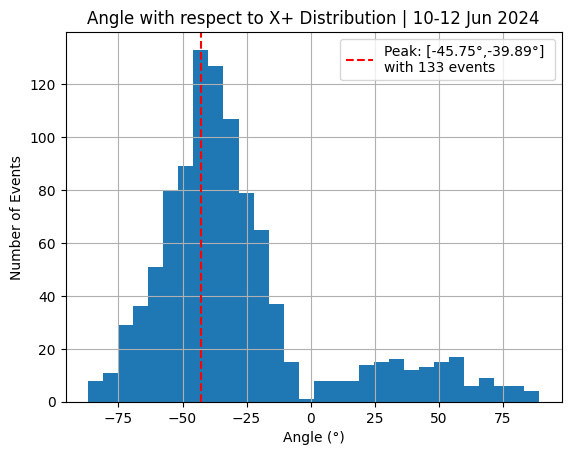

In [25]:
data = np.asarray(directions_ls).flatten()

# Graficar histograma y capturar valores
counts, bin_edges, _ = plt.hist(data, bins=30)
plt.title(f"Angle with respect to X+ Distribution | {date}")
plt.xlabel("Angle (°)")
plt.ylabel("Number of Events")

plt.grid(True)
# Encontrar índice del bin con más elementos
max_index = np.argmax(counts)

# Get the limits and center of the most populated bin
bin_start = bin_edges[max_index]
bin_end = bin_edges[max_index + 1]
bin_center = (bin_start + bin_end) / 2
count = int(counts[max_index])

# Add vertical line at the center of the most populated bin
plt.axvline(
    bin_center,
    color='red',
    linestyle='--',
    label=f"Peak: [{bin_start:.2f}°,{bin_end:.2f}°] \nwith {count} events"
)
plt.legend()
fname=valid_filename(f"Angle with respect to X+ Distribution | {date}")
fname=os.path.join(dir_plots,fname)
plt.savefig(fname, bbox_inches='tight')
plt.show()

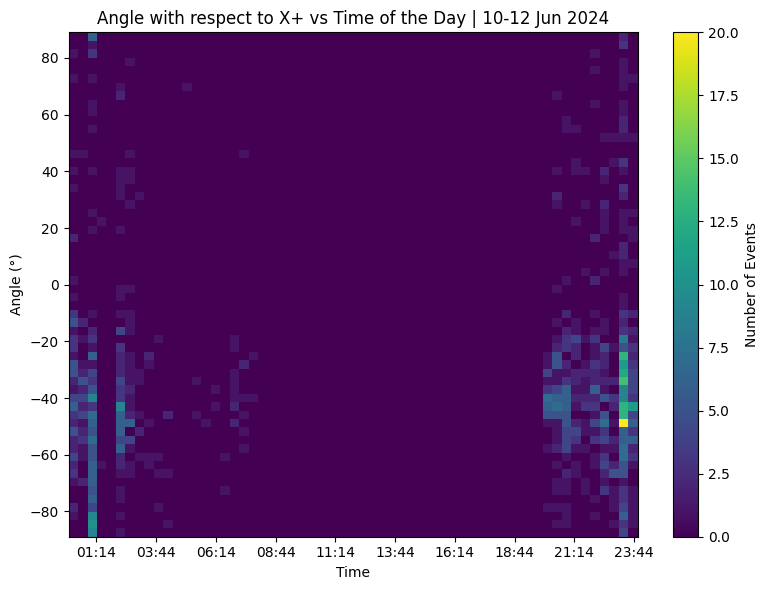

In [16]:
times_fixed_date = [datetime(2000, 1, 1, t.hour, t.minute, t.second) for t in times_ls]

# Convert datetime to float (number of days since 0001-01-01)
times_float = mdates.date2num(times_fixed_date)

# Create the plot
plt.figure(figsize=(8, 6))
plt.hist2d(times_float, np.asarray(directions_ls).flatten(), bins=60, cmap='viridis')

# Format the x-axis to show time (HH:MM)
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Optional: Increase the number of x-axis ticks (e.g., every 30 minutes)
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=150))

plt.colorbar(label='Number of Events')
plt.xlabel("Time")
plt.ylabel("Angle (°)")
plt.title(f"Angle with respect to X+ vs Time of the Day | {date}")
plt.tight_layout()
fname=valid_filename(f"Angle with respect to X+ vs Time of the Day | {date}" )
fname=os.path.join(dir_plots,fname)
plt.savefig(fname, bbox_inches='tight')
plt.show()